# Time series forecasting

This notebook adapts the Tensorflow tutorial on [Time series forecasting](https://www.tensorflow.org/tutorials/structured_data/time_series) to data generated from a model for epidemic processes. 

## Steps

1. Imports and setup
2. Load and prepare the generated data
3. Baseline forecasting
4. Univariate GRU based forecasting
5. Multivariate GRU based forecasting - Single Step
6. Multivariate GRU based forecasting - Multiple Steps

## Imports and setup

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import load_model
import pickle
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

## Load and prepare the generated data

We load data from the ODE model introduced in the notebook "Probability and Information Theory". For each of the 150 virtuel outbreaks (randomized and with different model parameters), we have time series (with 500 steps) for four the variables "Susceptible", "Infected", "Recovered", and "Deceased".

In [ ]:
csv_path = "./data/epidemic_process_raw_data.csv"
df = pd.read_csv(csv_path)
df.head()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501
0,100.287149,103.541223,95.879814,96.354848,96.980932,97.855310,98.940537,100.187494,98.265709,95.307794,94.580647,93.992711,93.404776,92.816841,92.343730,92.696064,93.048399,93.400734,93.753069,94.236025,95.019488,95.802950,96.586413,97.369875,97.720446,97.609199,97.497951,97.386704,97.275457,97.139052,96.989957,96.840862,96.691766,96.542671,96.393575,96.234205,95.815136,95.396066,94.976997,94.557927,...,4.903138,4.905420,4.907702,4.909983,4.912265,4.914546,4.916828,4.919109,4.916230,4.912608,4.908987,4.905365,4.901743,4.898121,4.894500,4.890878,4.887256,4.883634,4.880013,4.876391,4.869256,4.856246,4.843236,4.830226,4.817217,4.823850,4.847856,4.871862,4.895867,4.919873,4.925236,4.922108,4.918981,4.915853,4.912726,4.950240,4.995291,5.040342,5.085393,5.130445
1,0.993774,1.017558,1.070030,1.116168,1.142078,1.134735,1.182418,1.272310,1.356565,1.438978,1.479824,1.518077,1.556330,1.594583,1.638663,1.724638,1.810612,1.896586,1.982561,2.064897,2.138863,2.212829,2.286795,2.360761,2.441896,2.530679,2.619462,2.708246,2.797029,2.903927,3.019964,3.136000,3.252037,3.368073,3.484109,3.599962,3.711169,3.822377,3.933584,4.044791,...,0.617785,0.608541,0.599298,0.590054,0.580811,0.571568,0.562324,0.553081,0.546143,0.539538,0.532933,0.526327,0.519722,0.513116,0.506511,0.499905,0.493300,0.486694,0.480089,0.473484,0.466587,0.459203,0.451819,0.444435,0.437051,0.429563,0.421983,0.414403,0.406823,0.399243,0.391775,0.384359,0.376942,0.369526,0.362109,0.356669,0.351595,0.346521,0.341447,0.336374
2,0.000000,0.017741,0.036585,0.054735,0.074266,0.096065,0.117691,0.139184,0.163615,0.189006,0.215565,0.242196,0.268828,0.295460,0.322870,0.355873,0.388876,0.421879,0.454882,0.488543,0.523716,0.558890,0.594063,0.629237,0.669059,0.713840,0.758622,0.803403,0.848184,0.903379,0.963828,1.024276,1.084724,1.145172,1.205620,1.265729,1.317255,1.368780,1.420306,1.471832,...,94.951959,94.858256,94.764553,94.670851,94.577148,94.483445,94.389743,94.296040,94.110579,93.911917,93.713255,93.514592,93.315930,93.117268,92.918605,92.719943,92.521281,92.322618,92.123956,91.925294,91.618992,91.132694,90.646397,90.160099,89.673801,90.389580,92.168505,93.947429,95.726354,97.505279,97.247764,96.062916,94.878068,93.693219,92.508371,92.617122,92.965783,93.314443,93.663103,94.011764
3,0.000000,0.000178,0.000364,0.000562,0.000757,0.000947,0.001160,0.001389,0.001635,0.001887,0.002123,0.002357,0.002592,0.002826,0.003078,0.003454,0.003830,0.004206,0.004581,0.004976,0.005415,0.005854,0.006293,0.006732,0.007160,0.007575,0.007991,0.008406,0.008822,0.009302,0.009813,0.010325,0.010837,0.011349,0.011861,0.012382,0.013129,0.013877,0.014624,0.015372,...,0.924234,0.925477,0.926719,0.927962,0.929204,0.930447,0.931690,0.932932,0.933680,0.934357,0.935034,0.935711,0.936388,0.937065,0.937742,0.938419,0.939096,0.939773,0.940450,0.941127,0.941993,0.943176,0.944359,0.945543,0.946726,0.947035,0.946571,0.946107,0.945643,0.945179,0.947347,0.950713,0.954079,0.957445,0.960811,0.959320,0.956929,0.954537,0.952146,0.949755
4,103.489688,100.282780,96.634270,98.532514,99.089272,97.440900,98.416534,101.404903,100.480758,98.277282,99.034062,99.975577,100.917093,101.658396,100.214137,98.769877,97.325617,96.314936,96.784277,97.253618,97.722959,97.794299,97.185736,96.577173,95.968611,95.080232,93.925042,92.769852,91.614661,90.459471,89.864955,90.046987,90.229019,90.411052,90.593084,90.826629,91.166352,91.506075,91.845798,92.185521,...,2.197019,2.203810,2.210600,2.217390,2.224180,2.230971,2.237761,2.244551,2.251341,2.250477,2.233471,2.216466,2.199460,2.182454,2.165449,2.148443,2.131438,2.126144,2.124939,2.123733,2.122528,2.121323,2.120117,2.118912,2.116701,2.109244,2.101787,2.094330,2.086872,2.079415,2.071958,2.064501,2.072213,2.090890,2.109567,2.128244,

In [ ]:
dfSusceptible = df[df.index % 4 == 0]
dfSusceptible.head()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501
0,100.287149,103.541223,95.879814,96.354848,96.980932,97.855310,98.940537,100.187494,98.265709,95.307794,94.580647,93.992711,93.404776,92.816841,92.343730,92.696064,93.048399,93.400734,93.753069,94.236025,95.019488,95.802950,96.586413,97.369875,97.720446,97.609199,97.497951,97.386704,97.275457,97.139052,96.989957,96.840862,96.691766,96.542671,96.393575,96.234205,95.815136,95.396066,94.976997,94.557927,...,4.903138,4.905420,4.907702,4.909983,4.912265,4.914546,4.916828,4.919109,4.916230,4.912608,4.908987,4.905365,4.901743,4.898121,4.894500,4.890878,4.887256,4.883634,4.880013,4.876391,4.869256,4.856246,4.843236,4.830226,4.817217,4.823850,4.847856,4.871862,4.895867,4.919873,4.925236,4.922108,4.918981,4.915853,4.912726,4.950240,4.995291,5.040342,5.085393,5.130445
4,103.489688,100.282780,96.634270,98.532514,99.089272,97.440900,98.416534,101.404903,100.480758,98.277282,99.034062,99.975577,100.917093,101.658396,100.214137,98.769877,97.325617,96.314936,96.784277,97.253618,97.722959,97.794299,97.185736,96.577173,95.968611,95.080232,93.925042,92.769852,91.614661,90.459471,89.864955,90.046987,90.229019,90.411052,90.593084,90.826629,91.166352,91.506075,91.845798,92.185521,...,2.197019,2.203810,2.210600,2.217390,2.224180,2.230971,2.237761,2.244551,2.251341,2.250477,2.233471,2.216466,2.199460,2.182454,2.165449,2.148443,2.131438,2.126144,2.124939,2.123733,2.122528,2.121323,2.120117,2.118912,2.116701,2.109244,2.101787,2.094330,2.086872,2.079415,2.071958,2.064501,2.072213,2.090890,2.109567,2.128244,2.146921,2.165597,2.184274,2.202951
8,101.527421,97.711732,96.168179,95.677962,95.575326,96.109792,96.943831,98.007655,98.132798,97.951008,98.491940,99.077973,99.664006,100.250039,100.836072,101.422105,102.008138,102.594171,103.180204,102.620495,101.903987,101.187479,100.470970,99.754462,99.037954,98.321446,97.604938,96.888430,96.799758,96.850793,96.901828,96.952864,97.003899,97.054934,97.105969,97.157004,97.208040,96.922533,96.528610,96.134686,...,49.065540,49.136302,49.207064,49.277826,49.348588,49.419350,49.490112,49.560874,49.631635,49.702397,49.773159,49.843921,49.854108,49.750477,49.646846,49.543215,49.439585,49.335954,49.232323,49.128693,49.025062,48.921431,48.817801,48.714170,48.610539,48.506908,48.495624,48.529072,48.562519,48.595967,48.629414,48.662862,48.696309,48.729757,48.763204,48.796652,48.830099,48.863547,48.896994,48.930442
12,101.061107,99.112815,106.651686,101.622904,97.726686,95.692173,97.438263,102.084252,101.831030,99.975843,99.139330,98.366389,97.593447,96.820505,97.055369,98.706725,100.358082,102.009438,103.660795,102.735370,101.491987,100.248605,99.005222,98.108846,97.817184,97.525523,97.233861,96.942200,96.390044,95.787924,95.185803,94.583682,93.981562,93.379441,92.958834,92.621053,92.283272,91.945491,91.607709,91.269928,...,4.189201,4.201773,4.214344,4.226916,4.239488,4.252060,4.264632,4.277204,4.272239,4.221548,4.170857,4.120166,4.069475,4.018784,3.968093,3.917403,3.898083,3.915901,3.933720,3.951539,3.969358,3.987176,4.004995,4.022814,4.015908,3.995011,3.974114,3.953217,3.932320,3.911423,3.890526,3.869629,3.894123,3.928628,3.963133,3.997638,4.032143,4.066648,4.101153,4.135658
16,101.957189,101.898022,100.881113,99.892000,98.939878,98.048565,98.220024,99.206678,99.067041,98.559123,98.272076,97.998811,97.725547,97.452283,97.179018,97.993367,98.933811,99.874254,100.814697,101.755141,101.163507,100.303532,99.443558,98.583583,97.723608,98.416813,99.484328,100.551844,101.619359,102.686875,102.030404,100.831460,99.632517,98.433574,97.234630,96.035687,94.836744,94.627297,94.721002,94.814707,...,5.717379,5.712967,5.711187,5.719964,5.728741,5.737518,5.746296,5.755073,5.763850,5.772627,5.781404,5.790181,5.798958,5.807735,5.816512,5.805704,5.786488,5.767271,5.7480

In [ ]:
dfInfected = df[df.index % 4 == 1]
dfInfected.head()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501
1,0.993774,1.017558,1.070030,1.116168,1.142078,1.134735,1.182418,1.272310,1.356565,1.438978,1.479824,1.518077,1.556330,1.594583,1.638663,1.724638,1.810612,1.896586,1.982561,2.064897,2.138863,2.212829,2.286795,2.360761,2.441896,2.530679,2.619462,2.708246,2.797029,2.903927,3.019964,3.136000,3.252037,3.368073,3.484109,3.599962,3.711169,3.822377,3.933584,4.044791,...,0.617785,0.608541,0.599298,0.590054,0.580811,0.571568,0.562324,0.553081,0.546143,0.539538,0.532933,0.526327,0.519722,0.513116,0.506511,0.499905,0.493300,0.486694,0.480089,0.473484,0.466587,0.459203,0.451819,0.444435,0.437051,0.429563,0.421983,0.414403,0.406823,0.399243,0.391775,0.384359,0.376942,0.369526,0.362109,0.356669,0.351595,0.346521,0.341447,0.336374
5,1.021677,1.045410,1.120324,1.175914,1.236878,1.306676,1.387931,1.477973,1.549873,1.615840,1.673751,1.731158,1.788565,1.848209,1.932257,2.016306,2.100355,2.204834,2.379052,2.553271,2.727489,2.871048,2.962234,3.053419,3.144604,3.297297,3.508640,3.719984,3.931327,4.142670,4.359177,4.582835,4.806493,5.030150,5.253808,5.518583,5.868109,6.217634,6.567160,6.916685,...,0.276418,0.272730,0.269043,0.265355,0.261668,0.257980,0.254293,0.250605,0.246917,0.243390,0.240200,0.237009,0.233819,0.230629,0.227439,0.224248,0.221058,0.216378,0.211178,0.205979,0.200779,0.195579,0.190379,0.185179,0.180610,0.179330,0.178051,0.176771,0.175492,0.174212,0.172933,0.171653,0.169739,0.167366,0.164993,0.162620,0.160247,0.157874,0.155501,0.153128
9,1.020043,1.011238,1.031122,1.048642,1.049479,1.022891,1.035862,1.079177,1.114531,1.147282,1.155039,1.161236,1.167433,1.173630,1.179827,1.186023,1.192220,1.198417,1.204614,1.209275,1.213725,1.218175,1.222625,1.227076,1.231526,1.235976,1.240426,1.244877,1.259901,1.277278,1.294656,1.312033,1.329411,1.346788,1.364166,1.381543,1.398921,1.412466,1.424778,1.437089,...,6.426668,6.430731,6.434795,6.438858,6.442921,6.446985,6.451048,6.455111,6.459175,6.463238,6.467301,6.471365,6.457230,6.408902,6.360574,6.312246,6.263918,6.215590,6.167262,6.118934,6.070607,6.022279,5.973951,5.925623,5.877295,5.828967,5.790899,5.757800,5.724702,5.691603,5.658505,5.625406,5.592308,5.559209,5.526111,5.493012,5.459914,5.426815,5.393717,5.360619
13,1.035248,1.014189,1.133178,1.135622,1.157984,1.213088,1.281406,1.359858,1.423234,1.481680,1.539957,1.598224,1.656491,1.714757,1.783061,1.865472,1.947882,2.030293,2.112704,2.201486,2.291054,2.380622,2.470191,2.559060,2.646712,2.734364,2.822016,2.909668,3.040835,3.180348,3.319861,3.459374,3.598887,3.738400,3.883114,4.030200,4.177287,4.324374,4.471460,4.618547,...,0.497248,0.490317,0.483386,0.476456,0.469525,0.462595,0.455664,0.448733,0.442116,0.436317,0.430518,0.424719,0.418920,0.413121,0.407322,0.401523,0.394198,0.385069,0.375939,0.366809,0.357680,0.348550,0.339420,0.330291,0.324129,0.319647,0.315165,0.310684,0.306202,0.301720,0.297238,0.292756,0.288433,0.284145,0.279857,0.275569,0.271280,0.266992,0.262704,0.258416
17,1.012666,1.016949,1.053194,1.097599,1.143640,1.192369,1.238880,1.283688,1.324305,1.363552,1.415180,1.467582,1.519983,1.572384,1.624786,1.686941,1.750228,1.813515,1.876801,1.940088,2.015699,2.093468,2.171237,2.249006,2.326776,2.420753,2.518636,2.616519,2.714403,2.812286,2.910782,3.009471,3.108161,3.206850,3.305539,3.404228,3.502917,3.614823,3.730779,3.846734,...,0.708566,0.696182,0.684596,0.676213,0.667829,0.659445,0.651061,0.642678,0.634294,0.625910,0.617526,0.609143,0.600759,0.592375,0.583991,0.576081,0.568375,0.560668,0.552961,0.545255,0.537548,0.529841,0.522134,0.514428,0.506721,0.499014,0.491308,0.484613,0.481976,0.479340,0.475822,0.467301,0.458779,0.450518,0.444609,0.438701,0.432715,0.425247,0.417780,0.410313


In [ ]:
dfRecovered = df[df.index % 4 == 2]
dfRecovered.head()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501
2,0.0,0.017741,0.036585,0.054735,0.074266,0.096065,0.117691,0.139184,0.163615,0.189006,0.215565,0.242196,0.268828,0.295460,0.322870,0.355873,0.388876,0.421879,0.454882,0.488543,0.523716,0.558890,0.594063,0.629237,0.669059,0.713840,0.758622,0.803403,0.848184,0.903379,0.963828,1.024276,1.084724,1.145172,1.205620,1.265729,1.317255,1.368780,1.420306,1.471832,...,94.951959,94.858256,94.764553,94.670851,94.577148,94.483445,94.389743,94.296040,94.110579,93.911917,93.713255,93.514592,93.315930,93.117268,92.918605,92.719943,92.521281,92.322618,92.123956,91.925294,91.618992,91.132694,90.646397,90.160099,89.673801,90.389580,92.168505,93.947429,95.726354,97.505279,97.247764,96.062916,94.878068,93.693219,92.508371,92.617122,92.965783,93.314443,93.663103,94.011764
6,0.0,0.017909,0.035748,0.056118,0.076620,0.097338,0.119592,0.143024,0.171253,0.201050,0.230217,0.259345,0.288473,0.318281,0.355513,0.392745,0.429977,0.469247,0.515473,0.561698,0.607923,0.655632,0.705874,0.756117,0.806359,0.865670,0.933629,1.001588,1.069546,1.137505,1.212816,1.298309,1.383803,1.469296,1.554790,1.649005,1.761197,1.873388,1.985580,2.097772,...,93.873045,93.914033,93.955021,93.996009,94.036997,94.077985,94.118973,94.159961,94.200949,94.211268,94.156917,94.102567,94.048216,93.993866,93.939515,93.885164,93.830814,93.688692,93.515936,93.343179,93.170422,92.997666,92.824909,92.652152,92.610948,93.256075,93.901202,94.546330,95.191457,95.836584,96.481711,97.126839,97.050590,96.452872,95.855153,95.257435,94.659716,94.061998,93.464279,92.866561
10,0.0,0.016990,0.034644,0.052866,0.071444,0.090609,0.108733,0.126058,0.142408,0.158437,0.178711,0.199249,0.219787,0.240325,0.260863,0.281402,0.301940,0.322478,0.343016,0.362628,0.382112,0.401596,0.421081,0.440565,0.460050,0.479534,0.499018,0.518503,0.541009,0.564187,0.587365,0.610543,0.633722,0.656900,0.680078,0.703256,0.726434,0.751528,0.777238,0.802948,...,42.839919,43.025470,43.211021,43.396572,43.582123,43.767673,43.953224,44.138775,44.324326,44.509877,44.695428,44.880979,44.985959,44.939554,44.893148,44.846742,44.800337,44.753931,44.707526,44.661120,44.614715,44.568309,44.521904,44.475498,44.429093,44.382687,44.492986,44.679191,44.865397,45.051602,45.237808,45.424013,45.610219,45.796424,45.982629,46.168835,46.355040,46.541246,46.727451,46.913657
14,0.0,0.017002,0.036315,0.057484,0.078381,0.098831,0.119563,0.140509,0.166486,0.194109,0.218515,0.242719,0.266924,0.291129,0.319290,0.353013,0.386736,0.420459,0.454182,0.498052,0.543173,0.588294,0.633415,0.679935,0.728894,0.777852,0.826810,0.875769,0.930739,0.986862,1.042986,1.099110,1.155233,1.211357,1.278899,1.351653,1.424406,1.497160,1.569913,1.642667,...,97.141606,97.534519,97.927432,98.320345,98.713257,99.106170,99.499083,99.891996,99.939217,99.085094,98.230971,97.376847,96.522724,95.668601,94.814477,93.960354,93.656772,94.004944,94.353117,94.701290,95.049462,95.397635,95.745808,96.093980,95.898110,95.394358,94.890607,94.386855,93.883104,93.379353,92.875601,92.371850,92.874094,93.598211,94.322327,95.046444,95.770560,96.494677,97.218794,97.942910
18,0.0,0.017589,0.037434,0.056572,0.076275,0.096907,0.116533,0.135387,0.157592,0.180893,0.207562,0.234441,0.261321,0.288200,0.315079,0.345077,0.375437,0.405796,0.436156,0.466515,0.498081,0.529857,0.561634,0.593411,0.625187,0.665574,0.708035,0.750497,0.792958,0.835420,0.893515,0.956530,1.019544,1.082559,1.145574,1.208588,1.271603,1.331069,1.389448,1.447827,...,92.979453,92.859043,92.733596,92.587951,92.442305,92.296660,92.151015,92.005369,91.859724,91.714079,91.568433,91.422788,91.277143,91.131498,90.985852,91.149544,91.446053,91.742563,92.039073,92.335582,92.632092,92.928602,93.225111,93.521621,93.818131,94.114640,94.411150,94.572879,94.194174,93.815468,93.437562,93.064

In [ ]:
dfDead = df[df.index % 4 == 3]
dfDead.head()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501
3,0.0,0.000178,0.000364,0.000562,0.000757,0.000947,0.001160,0.001389,0.001635,0.001887,0.002123,0.002357,0.002592,0.002826,0.003078,0.003454,0.003830,0.004206,0.004581,0.004976,0.005415,0.005854,0.006293,0.006732,0.007160,0.007575,0.007991,0.008406,0.008822,0.009302,0.009813,0.010325,0.010837,0.011349,0.011861,0.012382,0.013129,0.013877,0.014624,0.015372,...,0.924234,0.925477,0.926719,0.927962,0.929204,0.930447,0.931690,0.932932,0.933680,0.934357,0.935034,0.935711,0.936388,0.937065,0.937742,0.938419,0.939096,0.939773,0.940450,0.941127,0.941993,0.943176,0.944359,0.945543,0.946726,0.947035,0.946571,0.946107,0.945643,0.945179,0.947347,0.950713,0.954079,0.957445,0.960811,0.959320,0.956929,0.954537,0.952146,0.949755
7,0.0,0.000175,0.000351,0.000558,0.000763,0.000968,0.001196,0.001443,0.001719,0.002004,0.002305,0.002607,0.002909,0.003214,0.003557,0.003899,0.004242,0.004619,0.005115,0.005610,0.006106,0.006616,0.007152,0.007688,0.008224,0.008830,0.009504,0.010178,0.010852,0.011526,0.012240,0.013011,0.013782,0.014553,0.015324,0.016237,0.017445,0.018652,0.019860,0.021067,...,0.965853,0.965985,0.966116,0.966248,0.966379,0.966511,0.966642,0.966774,0.966905,0.965979,0.962821,0.959663,0.956505,0.953348,0.950190,0.947032,0.943874,0.948192,0.955120,0.962048,0.968975,0.975903,0.982831,0.989758,0.995401,0.994336,0.993272,0.992208,0.991144,0.990080,0.989016,0.987952,0.986532,0.984855,0.983178,0.981502,0.979825,0.978148,0.976471,0.974794
11,0.0,0.000171,0.000352,0.000538,0.000729,0.000927,0.001126,0.001324,0.001488,0.001642,0.001837,0.002034,0.002231,0.002427,0.002624,0.002821,0.003018,0.003215,0.003412,0.003640,0.003873,0.004105,0.004338,0.004571,0.004803,0.005036,0.005269,0.005501,0.005735,0.005970,0.006205,0.006439,0.006674,0.006909,0.007143,0.007378,0.007612,0.007872,0.008141,0.008409,...,0.441141,0.441222,0.441304,0.441386,0.441468,0.441549,0.441631,0.441713,0.441795,0.441876,0.441958,0.442040,0.442332,0.443018,0.443705,0.444392,0.445078,0.445765,0.446452,0.447138,0.447825,0.448512,0.449199,0.449885,0.450572,0.451259,0.451931,0.452596,0.453260,0.453925,0.454590,0.455255,0.455920,0.456585,0.457250,0.457914,0.458579,0.459244,0.459909,0.460574
15,0.0,0.000181,0.000364,0.000563,0.000774,0.001003,0.001192,0.001351,0.001575,0.001822,0.002120,0.002421,0.002722,0.003023,0.003327,0.003634,0.003941,0.004248,0.004556,0.004948,0.005351,0.005753,0.006156,0.006562,0.006975,0.007388,0.007801,0.008214,0.008776,0.009367,0.009958,0.010549,0.011139,0.011730,0.012434,0.013189,0.013944,0.014699,0.015454,0.016209,...,0.961106,0.962488,0.963871,0.965253,0.966636,0.968018,0.969401,0.970783,0.970497,0.965858,0.961219,0.956580,0.951941,0.947303,0.942664,0.938025,0.935230,0.934619,0.934007,0.933395,0.932783,0.932171,0.931559,0.930947,0.932684,0.935750,0.938816,0.941882,0.944947,0.948013,0.951079,0.954145,0.954334,0.953888,0.953443,0.952997,0.952552,0.952106,0.951661,0.951215
19,0.0,0.000180,0.000358,0.000550,0.000740,0.000931,0.001138,0.001359,0.001574,0.001787,0.002052,0.002320,0.002587,0.002855,0.003123,0.003415,0.003710,0.004006,0.004301,0.004597,0.004959,0.005334,0.005708,0.006083,0.006457,0.006894,0.007346,0.007798,0.008250,0.008702,0.009189,0.009686,0.010183,0.010680,0.011177,0.011675,0.012172,0.012852,0.013589,0.014326,...,0.920504,0.917698,0.915494,0.915704,0.915914,0.916124,0.916333,0.916543,0.916753,0.916963,0.917173,0.917383,0.917593,0.917803,0.918013,0.920137,0.923083,0.926029,0.928975,0.931921,0.934867,0.937813,0.940759,0.943704,0.946650,0.949596,0.952542,0.956393,0.963869,0.971346,0.975329,0.959467,0.943605,0.929243,0.928406,0.927568,0.927127,0.934226,0.941326,0.948426


Below a plot of three infection time series for the three first outbreaks.

143 33.9124768491609
32.7035320395393
35.97198029791429
0.351581606839808


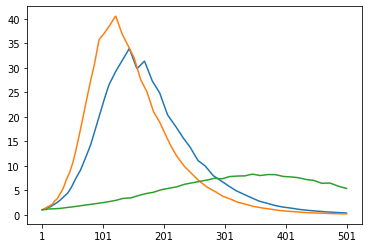

In [ ]:
# For the blue outbreak, days and then values
print(np.argmax(dfInfected.loc[1]), dfInfected.loc[1][np.argmax(dfInfected.loc[1])])
print(dfSusceptible.loc[0][np.argmax(dfInfected.loc[1])])
print(dfRecovered.loc[2][np.argmax(dfInfected.loc[1])])
print(dfDead.loc[3][np.argmax(dfInfected.loc[1])])

dfInfected.loc[1,:].plot()
dfInfected.loc[5,:].plot()
dfInfected.loc[9,:].plot()

### Convert to numpy for usage later (personal preference to numpy than pandas)

In [ ]:
# # convert pandas to np
npInfected = dfInfected.to_numpy()
npSusceptible = dfSusceptible.to_numpy()
npRecovered = dfRecovered.to_numpy()
npDead = dfDead.to_numpy()

We define a 90% / 10% of data for training / testing.

In [ ]:
dfInfected_arr = dfInfected.values
dfInfected_arr.shape
TRAIN_SPLIT = int(dfInfected_arr.shape[0]-dfInfected_arr.shape[0]*0.1)
TRAIN_SPLIT

135

We standardize the data.

In [ ]:
uni_train_mean = dfInfected_arr[:TRAIN_SPLIT].mean()
uni_train_std = dfInfected_arr[:TRAIN_SPLIT].std()
uni_data = (dfInfected_arr-uni_train_mean)/uni_train_std
print ('\n Univariate data shape')
print(uni_data.shape)


 Univariate data shape
(150, 501)


We split the data into time series of `univariate_past_history=20` days length and predict the future of the current day, i.e., `univariate_future_target=0`, for the "infected" variable. 

In [ ]:
def univariate_data(dataset, start_series, end_series, history_size, target_size):
    data = []
    labels = []
    start_index = history_size
    end_index = len(dataset[0]) - target_size   
    for c in range(start_series, end_series):
        for i in range(start_index, end_index):
            indices = range(i-history_size, i)
            # Reshape data from (history_size,) to (history_size, 1)
            data.append(np.reshape(dataset[c][indices], (history_size, 1)))
            labels.append(dataset[c][i+target_size])
    return np.array(data), np.array(labels)

In [ ]:
univariate_past_history = 20 #days
univariate_future_target = 0 #current day

x_train_uni, y_train_uni = univariate_data(uni_data, 0, TRAIN_SPLIT,
                                           univariate_past_history,
                                           univariate_future_target)
x_val_uni, y_val_uni = univariate_data(uni_data, TRAIN_SPLIT, len(uni_data),
                                       univariate_past_history,
                                       univariate_future_target)


print(x_train_uni.shape, y_train_uni.shape)
print(x_val_uni.shape, y_val_uni.shape)

(64935, 20, 1) (64935,)
(7215, 20, 1) (7215,)


### Select three outbreaks for testing

For each outbreak, first find the height of infection using argmax. Next create a univariate dataset for all days leading up to that day.

In [ ]:
argmax0 = np.argmax( npInfected[len(npInfected)-1])
series0 = len(npInfected)-1

x_test_uni0, y_test_uni0 = univariate_data(uni_data, series0, len(npInfected),
                                       argmax0-1,
                                       univariate_future_target)

argmax1 = np.argmax( npInfected[len(npInfected)-10])
series1 = len(npInfected)-10
x_test_uni1, y_test_uni1 = univariate_data(uni_data, series1, len(npInfected)-9,
                                       argmax1-1,
                                       univariate_future_target)

argmax2 = np.argmax( npInfected[len(npInfected)-13])
series2 = len(npInfected)-13
x_test_uni2, y_test_uni2 = univariate_data(uni_data, series2, len(npInfected)-12,
                                       argmax2-1,
                                       univariate_future_target)

In [ ]:
def create_time_steps(length):
    return list(range(-length, 0))

In [ ]:
def show_plot(plot_data, delta, title):
    labels = ['History', 'True Future', 'Model Prediction']
    marker = ['.-', 'rx', 'go']
    time_steps = create_time_steps(plot_data[0].shape[0])
    if delta:
        future = delta
    else:
        future = 0
    plt.title(title)
    for i, x in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10,label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future+5)*2])
    plt.xlabel('Time-Step')
    return plt

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

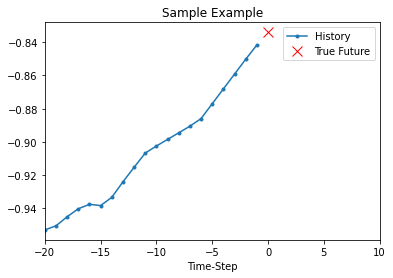

In [ ]:
show_plot([x_train_uni[0], y_train_uni[0]], 0, 'Sample Example')

### Plot of a single test outbreak leading up to peak infection

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

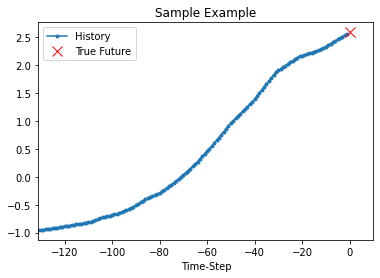

In [ ]:
show_plot([x_test_uni0[0], y_test_uni0[0]], 0, 'Sample Example')

## Baseline forecasting

Predicts the mean of the `history`.

In [ ]:
def baseline(history):
    return np.mean(history)

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

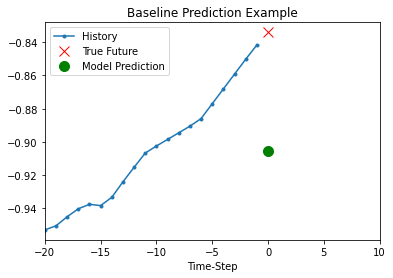

In [ ]:
show_plot([x_train_uni[0], y_train_uni[0], baseline(x_train_uni[0])], 0, 'Baseline Prediction Example')

### Three plots of the chosen test outbreaks

The plots have many more dots which equal the number of days prior to the peak infection date.


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

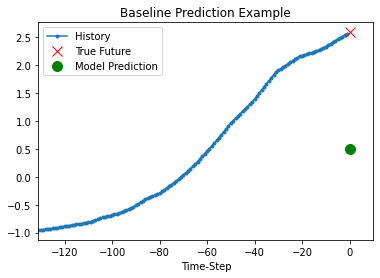

In [ ]:
show_plot([x_test_uni0[0], y_test_uni0[0], baseline(x_test_uni0[0])], 0, 'Baseline Prediction Example')

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

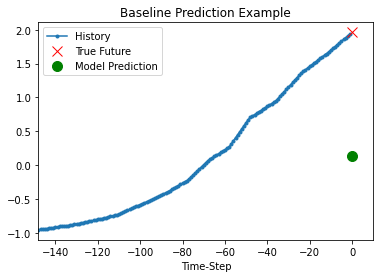

In [ ]:
show_plot([x_test_uni1[0], y_test_uni1[0], baseline(x_test_uni1[0])], 0, 'Baseline Prediction Example')

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

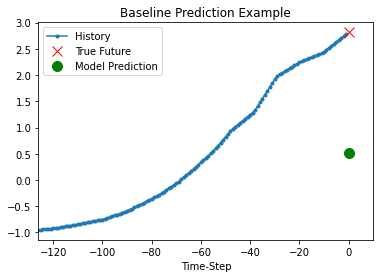

In [ ]:
show_plot([x_test_uni2[0], y_test_uni2[0], baseline(x_test_uni2[0])], 0, 'Baseline Prediction Example')

## Univariate GRU based forecasting

In [ ]:
print (x_train_uni.shape)
print (y_train_uni.shape)
x_train_uni.dtype

(64935, 20, 1)
(64935,)


dtype('float64')

Batching and resampling; the dataset is repeated indefinitely. Check the tutorial for the details.

In [ ]:
BATCH_SIZE = 256
BUFFER_SIZE = 10000

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

train_univariate

<RepeatDataset shapes: ((None, 20, 1), (None,)), types: (tf.float64, tf.float64)>

Create univariate data for each of the three chosen test outbreaks

In [ ]:
test_univariate0 = tf.data.Dataset.from_tensor_slices((x_test_uni0, y_test_uni0))
test_univariate0 = test_univariate0.batch(BATCH_SIZE).repeat()

test_univariate1 = tf.data.Dataset.from_tensor_slices((x_test_uni1, y_test_uni1))
test_univariate1 = test_univariate1.batch(BATCH_SIZE).repeat()

test_univariate2 = tf.data.Dataset.from_tensor_slices((x_test_uni2, y_test_uni2))
test_univariate2 = test_univariate2.batch(BATCH_SIZE).repeat()

We define the first GRU model with 8 units.

In [ ]:
simple_gru_model = tf.keras.models.Sequential([
    tf.keras.layers.GRU(8, input_shape=x_train_uni.shape[-2:]),
    tf.keras.layers.Dense(1)
])


simple_gru_model.compile(optimizer='adam', loss='mae')
# simple_gru_model.summary()
# x_train_uni.shape[-2:]

In [ ]:
for x, y in val_univariate.take(1):
    print(simple_gru_model.predict(x).shape)
    print(y.shape)

(256, 1)
(256,)


When passing an indefinitely repeated training data set, we need to specify the numbre of steps per training interval (epoch).

In [ ]:
EVALUATION_INTERVAL = 2000
EPOCHS = 12

simple_gru_model.fit(train_univariate, 
                      epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_univariate, 
                      validation_steps=50)



Epoch 1/12
2000/2000 [==============================] - 15s 6ms/step - loss: 0.0763 - val_loss: 0.0023
Epoch 2/12
2000/2000 [==============================] - 12s 6ms/step - loss: 0.0039 - val_loss: 0.0022
Epoch 3/12
2000/2000 [==============================] - 12s 6ms/step - loss: 0.0030 - val_loss: 0.0015
Epoch 4/12
2000/2000 [==============================] - 12s 6ms/step - loss: 0.0027 - val_loss: 0.0025
Epoch 5/12
2000/2000 [==============================] - 12s 6ms/step - loss: 0.0025 - val_loss: 0.0017
Epoch 6/12
2000/2000 [==============================] - 12s 6ms/step - loss: 0.0023 - val_loss: 0.0019
Epoch 7/12
2000/2000 [==============================] - 12s 6ms/step - loss: 0.0023 - val_loss: 0.0017
Epoch 8/12
2000/2000 [==============================] - 12s 6ms/step - loss: 0.0022 - val_loss: 0.0023
Epoch 9/12
2000/2000 [==============================] - 12s 6ms/step - loss: 0.0021 - val_loss: 0.0012
Epoch 10/12
2000/2000 [==============================] - 12s 6ms/step - l

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/data/simple_gru_model/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/data/simple_gru_model/assets


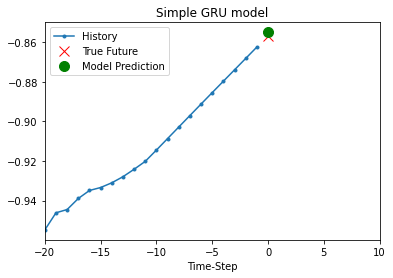

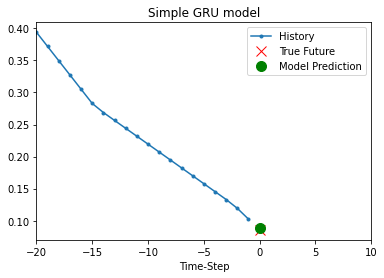

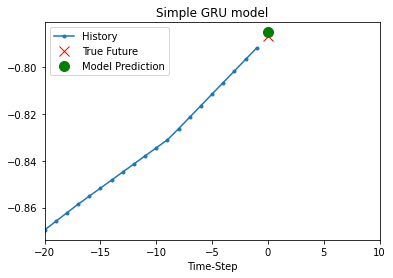

In [ ]:
for x, y in val_univariate.take(3):
    plot = show_plot([x[0].numpy(), y[0].numpy(), simple_gru_model.predict(x)[0]], 0, 'Simple GRU model')
    plot.show()

### Plot of the three chosen test outbreaks


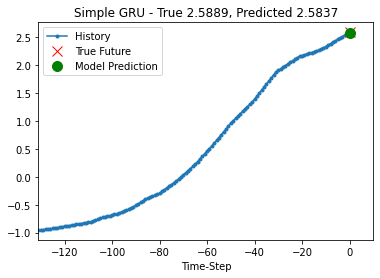

In [ ]:
for x, y in test_univariate0.take(1):
    plot_data = [x[0].numpy(), y[0].numpy(), simple_gru_model.predict(x)[0]]
    plot = show_plot(plot_data, 0, f'Simple GRU - True {y[0].numpy():.4f}, Predicted {simple_gru_model.predict(x)[0][0]:.4f}')
    plot.show()

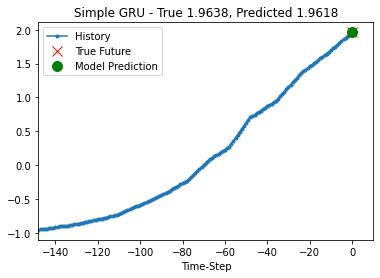

In [ ]:
for x, y in test_univariate1.take(1):
    plot_data = [x[0].numpy(), y[0].numpy(), simple_gru_model.predict(x)[0]]
    plot = show_plot(plot_data, 0, f'Simple GRU - True {y[0].numpy():.4f}, Predicted {simple_gru_model.predict(x)[0][0]:.4f}')
    plot.show()

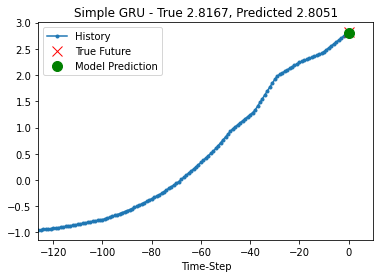

In [ ]:
for x, y in test_univariate2.take(1):
    plot_data = [x[0].numpy(), y[0].numpy(), simple_gru_model.predict(x)[0]]
    plot = show_plot(plot_data, 0, f'Simple GRU - True {y[0].numpy():.4f}, Predicted {simple_gru_model.predict(x)[0][0]:.4f}')
    plot.show()

## Multivariate GRU based forecasting - Single Step

We use three variables "Infected", "Recovered", and "Deceased", to forcast "Infected" at one single day in the future.

Here a plot of the time series of the three variables for one outbreak. 

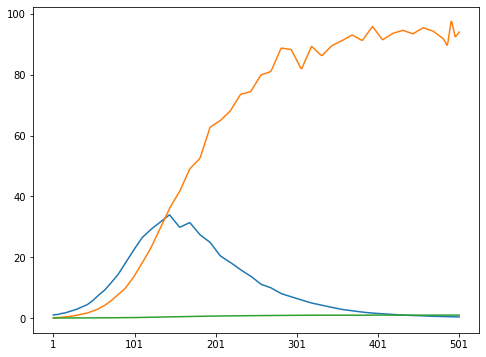

In [ ]:
dfInfected.loc[1,:].plot()
dfRecovered.loc[2,:].plot()
dfDead.loc[3,:].plot()
dfInfected = dfInfected.values
dfRecovered_arr = dfRecovered.values
dfDead_arr = dfDead.values

We prepare the dataset.

In [ ]:
#as before
dfInfected_train_mean = dfInfected_arr[:TRAIN_SPLIT].mean()
dfInfected_train_std = dfInfected_arr[:TRAIN_SPLIT].std()
dfInfected_data = (dfInfected_arr-dfInfected_train_mean)/dfInfected_train_std
#for Recovered
dfRecovered_train_mean = dfRecovered_arr[:TRAIN_SPLIT].mean()
dfRecovered_train_std = dfRecovered_arr[:TRAIN_SPLIT].std()
dfRecovered_data = (dfRecovered_arr-dfRecovered_train_mean)/dfRecovered_train_std
#for Dead
dfDead_train_mean = dfDead_arr[:TRAIN_SPLIT].mean()
dfDead_train_std = dfDead_arr[:TRAIN_SPLIT].std()
dfDead_data = (dfDead_arr-dfDead_train_mean)/dfDead_train_std

In [ ]:
dataset = np.array([dfInfected_data, dfRecovered_data, dfDead_data])
dataset.shape
print ('\n Multivariate data shape')
print(dataset.shape)


 Multivariate data shape
(3, 150, 501)


In [ ]:
def multivariate_data(dataset, target, start_series, end_series, history_size,
                      target_size, step, single_step=False):
    data = []
    labels = []
    start_index = history_size
    end_index = len(dataset[0][0]) - target_size   
    for c in range(start_series, end_series):
        for i in range(start_index, end_index):
            indices = range(i-history_size, i, step)
            one = dataset[0][c][indices]
            two = dataset[1][c][indices]
            three = dataset[2][c][indices]
            data.append(np.transpose(np.array([one, two, three])))
            
            if single_step:
                labels.append(target[c][i+target_size])
            else:
                labels.append(np.transpose(target[c][i:i+target_size]))
    return np.array(data), np.array(labels)

We get training and valdation data for time series with a `past_history = 20` days for every other day (`STEP = 2`) and want to predict the "Infected" five days ahead (`future_target = 5`).

In [ ]:
past_history = 20
future_target = 5
STEP = 2

x_train_single, y_train_single = multivariate_data(dataset, dfInfected_data, 0, TRAIN_SPLIT, 
                                                   past_history, future_target, STEP,
                                                   single_step=True)
x_val_single, y_val_single = multivariate_data(dataset, dfInfected_data, TRAIN_SPLIT, dataset.shape[1], 
                                               past_history, future_target, STEP,
                                               single_step=True)

x_test_single0, y_test_single0 = multivariate_data(dataset, dfInfected_data, series0, series0+1, 
                                               argmax0-1, future_target, STEP,
                                               single_step=True)

x_test_single1, y_test_single1 = multivariate_data(dataset, dfInfected_data, series1, series1+1, 
                                               argmax1-1, future_target, STEP,
                                               single_step=True)

x_test_single2, y_test_single2 = multivariate_data(dataset, dfInfected_data, series2, series2+1, 
                                               argmax2-1, future_target, STEP,
                                               single_step=True)



In [ ]:
print ('Single window of past history : {}'.format(x_train_single[0].shape))
print(dataset.shape)

Single window of past history : (10, 3)
(3, 150, 501)


As before, batching and resampling; the dataset is repeated indefinitely.

In [ ]:
train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()


test_data_single0 = tf.data.Dataset.from_tensor_slices((x_test_single0, y_test_single0))
test_data_single0 = test_data_single0.batch(BATCH_SIZE).repeat()

test_data_single1 = tf.data.Dataset.from_tensor_slices((x_test_single1, y_test_single1))
test_data_single1 = test_data_single1.batch(BATCH_SIZE).repeat()

test_data_single2 = tf.data.Dataset.from_tensor_slices((x_test_single2, y_test_single2))
test_data_single2 = test_data_single2.batch(BATCH_SIZE).repeat()

In [ ]:
single_step_model = tf.keras.models.Sequential()
single_step_model.add(tf.keras.layers.GRU(32, input_shape=x_train_single.shape[-2:]))
single_step_model.add(tf.keras.layers.Dense(1))

single_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')
single_step_model.summary()
x_train_single.shape[-2:]

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 32)                3552      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 3,585
Trainable params: 3,585
Non-trainable params: 0
_________________________________________________________________


(10, 3)

In [ ]:
for x, y in val_data_single.take(1):
    print(single_step_model.predict(x).shape)
print ('\n Number of traing data points')
print (x_train_single.shape[0])
print ('\n Number of test data points')
print (x_val_single.shape[0])

(256, 1)

 Number of traing data points
64260

 Number of test data points
7140


In [ ]:
single_step_history = single_step_model.fit(train_data_single, epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data_single,
                                            validation_steps=50)

Epoch 1/12
2000/2000 [==============================] - 13s 6ms/step - loss: 0.0388 - val_loss: 0.0225
Epoch 2/12
2000/2000 [==============================] - 11s 5ms/step - loss: 0.0239 - val_loss: 0.0216
Epoch 3/12
2000/2000 [==============================] - 11s 5ms/step - loss: 0.0208 - val_loss: 0.0170
Epoch 4/12
2000/2000 [==============================] - 11s 5ms/step - loss: 0.0191 - val_loss: 0.0161
Epoch 5/12
2000/2000 [==============================] - 11s 5ms/step - loss: 0.0180 - val_loss: 0.0171
Epoch 6/12
2000/2000 [==============================] - 11s 5ms/step - loss: 0.0174 - val_loss: 0.0165
Epoch 7/12
2000/2000 [==============================] - 11s 5ms/step - loss: 0.0168 - val_loss: 0.0151
Epoch 8/12
2000/2000 [==============================] - 11s 5ms/step - loss: 0.0163 - val_loss: 0.0148
Epoch 9/12
2000/2000 [==============================] - 11s 5ms/step - loss: 0.0158 - val_loss: 0.0133
Epoch 10/12
2000/2000 [==============================] - 11s 5ms/step - l

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/data/single_step_model/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/data/single_step_model/assets


In [ ]:
def plot_train_history(history, title):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(title)
    plt.legend()
    plt.show()

Plot with avg loss and avg val loss

In [ ]:
single_val_loss = np.mean(single_step_history.history["val_loss"])
single_loss = np.mean(single_step_history.history["loss"])

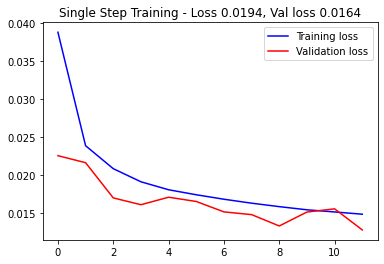

In [ ]:
plot_train_history(single_step_history,f'Single Step Training - Loss {single_loss:.4f}, Val loss {single_val_loss:.4f}')

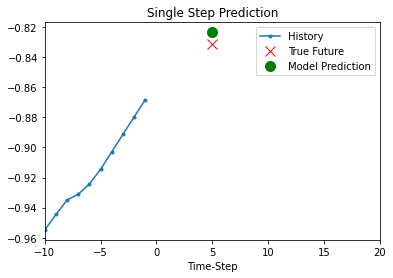

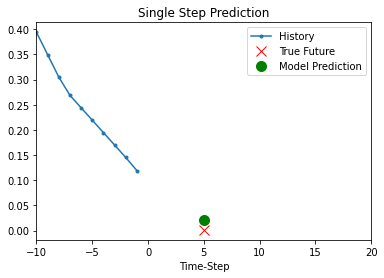

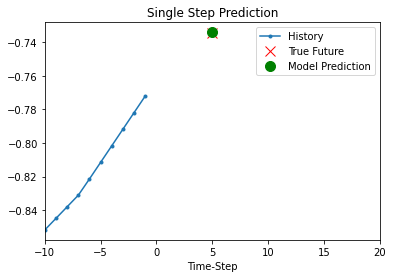

In [ ]:
for x, y in val_data_single.take(3):
    plot = show_plot([x[0][:, 0].numpy(), y[0].numpy(),
                    single_step_model.predict(x)[0]], future_target,
                   'Single Step Prediction')
    plot.show()

Plot of 3 chosen test outbreaks

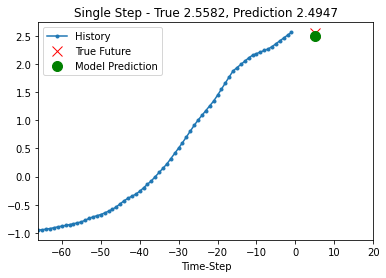

Single Step - True 2.5582, Prediction 2.4947


In [ ]:
for x, y in test_data_single0.take(1):
    plot = show_plot([x[0][:, 0].numpy(), y[0].numpy(),
                    single_step_model.predict(x)[0]], future_target,
                   f'Single Step - True {y[0].numpy():.4f}, Prediction {single_step_model.predict(x)[0][0]:.4f}')
    plot.show()

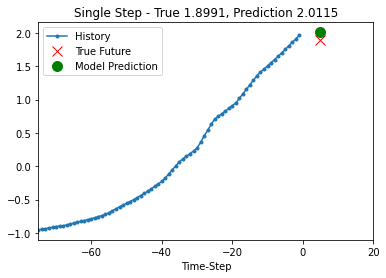

In [ ]:
for x, y in test_data_single1.take(1):
    plot = show_plot([x[0][:, 0].numpy(), y[0].numpy(),
                    single_step_model.predict(x)[0]], future_target,
                   f'Single Step - True {y[0].numpy():.4f}, Prediction {single_step_model.predict(x)[0][0]:.4f}')
    plot.show()

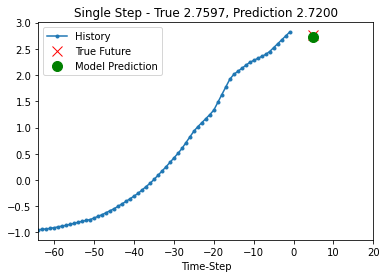

In [ ]:
for x, y in test_data_single2.take(1):
    plot = show_plot([x[0][:, 0].numpy(), y[0].numpy(),
                    single_step_model.predict(x)[0]], future_target,
                   f'Single Step - True {y[0].numpy():.4f}, Prediction {single_step_model.predict(x)[0][0]:.4f}')
    plot.show()

Please scroll down to "Single Step Predictions Around Peak" for additional predictions

## Multivariate GRU - Multiple Steps

Still, we use a series of observed values of the three variables "Infected", "Recovered", and "Deceased" (`past_history = 40, STEP =2`), but now to forcast the "Infected" values for a series day in the future (`future_target = 10`).

In [ ]:
past_history = 40
future_target = 10
STEP =2
x_train_multi, y_train_multi = multivariate_data(dataset, dfInfected_data, 0, TRAIN_SPLIT, 
                                                    past_history, future_target, STEP)

x_val_multi, y_val_multi = multivariate_data(dataset, dfInfected_data, TRAIN_SPLIT, dataset.shape[1], 
                                                past_history, future_target, STEP)

######### 
x_test_multi0, y_test_multi0 = multivariate_data(dataset, dfInfected_data, series0, series0+1, 
                                               argmax0, future_target, STEP)

x_test_multi1, y_test_multi1 = multivariate_data(dataset, dfInfected_data, series1, series1+1, 
                                               argmax1, future_target, STEP)

x_test_multi2, y_test_multi2 = multivariate_data(dataset, dfInfected_data, series2, series2+1, 
                                               argmax2, future_target, STEP)


In [ ]:
print ('Single window of past history : {}'.format(x_train_multi[0].shape))
print ('\nTarget window to predict : {}'.format(y_train_multi[0].shape))
print ('\nNumber of traing data points: {}'.format(x_train_multi.shape[0]))
print ('\nNumber of test data points: {}'.format(x_val_multi.shape[0]))

Single window of past history : (20, 3)

Target window to predict : (10,)

Number of traing data points: 60885

Number of test data points: 6765


As before, batching and resampling; the dataset is repeated indefinitely.

In [ ]:
train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

test_data_multi0 = tf.data.Dataset.from_tensor_slices((x_test_multi0, y_test_multi0))
test_data_multi0 = test_data_multi0.batch(BATCH_SIZE).repeat()

test_data_multi1 = tf.data.Dataset.from_tensor_slices((x_test_multi1, y_test_multi1))
test_data_multi1 = test_data_multi1.batch(BATCH_SIZE).repeat()

test_data_multi2 = tf.data.Dataset.from_tensor_slices((x_test_multi2, y_test_multi2))
test_data_multi2 = test_data_multi2.batch(BATCH_SIZE).repeat()

In [ ]:
def multi_step_plot(history, true_future, prediction, title=""):
    plt.figure(figsize=(12, 6))
    num_in = create_time_steps(len(history))
    num_out = len(true_future)
    plt.plot(num_in, np.array(history[:, 0]), label='History')
    plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo', label='True Future')
    if prediction.any():
        plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro', label='Predicted Future')
    plt.legend(loc='upper left')
    plt.title(title)
    plt.show()

(20, 3) (10,)


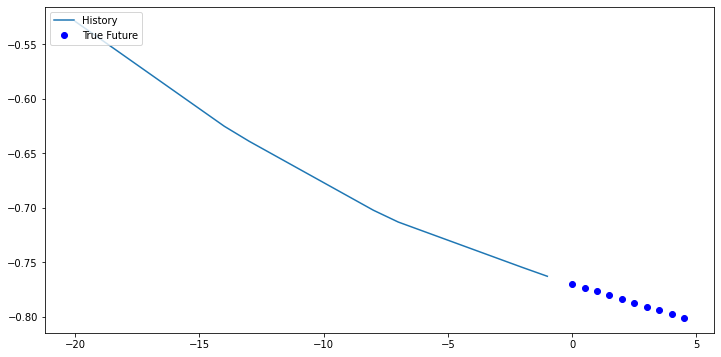

In [ ]:
for x, y in train_data_multi.take(1):
    multi_step_plot(x[0], y[0], np.array([0]))

Now we bild a model with two GRU layers.

In [ ]:
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.GRU(32,
                                          return_sequences=True,
                                          input_shape=x_train_multi.shape[-2:]))
multi_step_model.add(tf.keras.layers.GRU(16, activation='relu'))
multi_step_model.add(tf.keras.layers.Dense(future_target))

multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')
multi_step_model.summary()
x_train_multi.shape[-2:]

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_4 (GRU)                  (None, 20, 32)            3552      
_________________________________________________________________
gru_5 (GRU)                  (None, 16)                2400      
_________________________________________________________________
dense_3 (Dense)              (None, 10)                170       
Total params: 6,122
Trainable params: 6,122
Non-trainable params: 0
_________________________________________________________________


(20, 3)

In [ ]:
for x, y in val_data_multi.take(1):
    print (multi_step_model.predict(x).shape)

(256, 10)


The training time is longer for this more complex model.

In [ ]:
multi_step_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_multi,
                                          validation_steps=50)

Epoch 1/12
2000/2000 [==============================] - 153s 75ms/step - loss: 0.0583 - val_loss: 0.0224
Epoch 2/12
2000/2000 [==============================] - 149s 74ms/step - loss: 0.0274 - val_loss: 0.0246
Epoch 3/12
2000/2000 [==============================] - 149s 75ms/step - loss: 0.0237 - val_loss: 0.0228
Epoch 4/12
2000/2000 [==============================] - 148s 74ms/step - loss: 0.0215 - val_loss: 0.0224
Epoch 5/12
2000/2000 [==============================] - 148s 74ms/step - loss: 0.0200 - val_loss: 0.0210
Epoch 6/12
2000/2000 [==============================] - 148s 74ms/step - loss: 0.0188 - val_loss: 0.0151
Epoch 7/12
2000/2000 [==============================] - 148s 74ms/step - loss: 0.0179 - val_loss: 0.0137
Epoch 8/12
2000/2000 [==============================] - 148s 74ms/step - loss: 0.0173 - val_loss: 0.0180
Epoch 9/12
2000/2000 [==============================] - 148s 74ms/step - loss: 0.0168 - val_loss: 0.0149
Epoch 10/12
2000/2000 [==============================] 

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/data/multi_step_model/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/data/multi_step_model/assets


Plot and show avg loss and avg val loss

In [ ]:
avg_loss = np.mean(multi_step_history.history["loss"])
avg_val_loss = np.mean(multi_step_history.history["val_loss"])

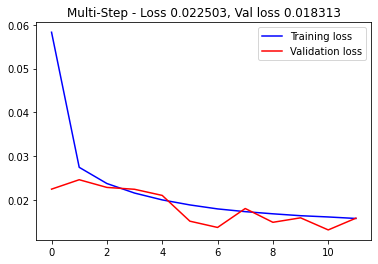

In [ ]:
plot_train_history(multi_step_history, f'Multi-Step - Loss {avg_loss:4f}, Val loss {avg_val_loss:4f}')

(20, 3) (10,)


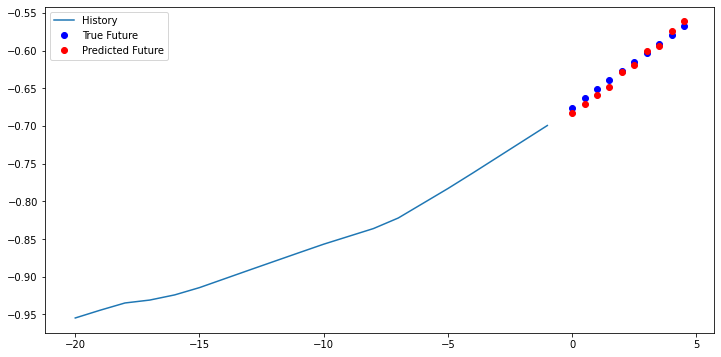

(20, 3) (10,)


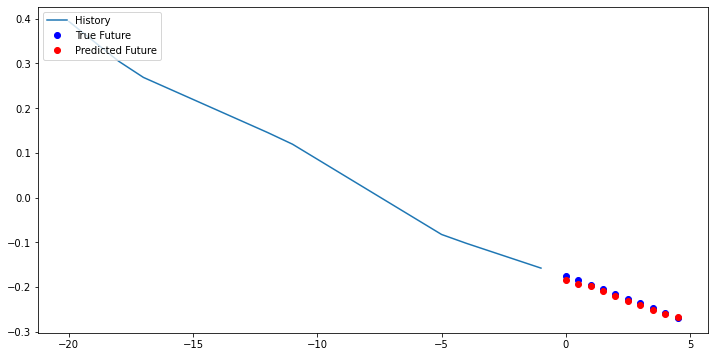

(20, 3) (10,)


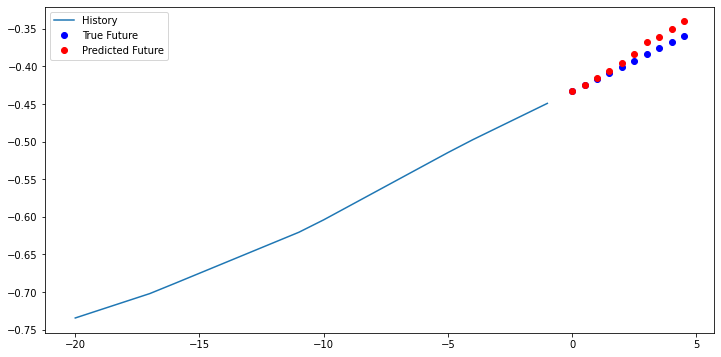

In [ ]:
for x, y in val_data_multi.take(3):
    multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0])

Please scroll down to "Multi Step Predictions Around Peak" for test predictions

## Single Step Predictions Around Peak

### 5 days before peak, predict peak

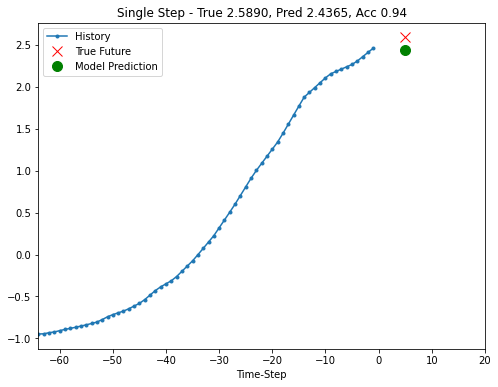

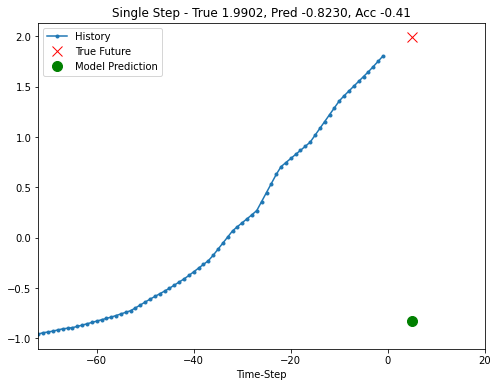

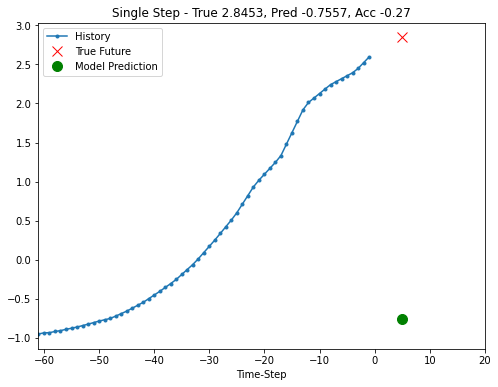

In [ ]:
past_history = 5
future_target = 5
STEP = 2

x_test_single0, y_test_single0 = multivariate_data(dataset, dfInfected_data, series0, series0+1, 
                                               argmax0-past_history, future_target, STEP,
                                               single_step=True)

x_test_single1, y_test_single1 = multivariate_data(dataset, dfInfected_data, series1, series1+1, 
                                               argmax1-past_history, future_target, STEP,
                                               single_step=True)

x_test_single2, y_test_single2 = multivariate_data(dataset, dfInfected_data, series2, series2+1, 
                                               argmax2-past_history, future_target, STEP,
                                               single_step=True)

test_data_single0 = tf.data.Dataset.from_tensor_slices((x_test_single0, y_test_single0))
test_data_single0 = test_data_single0.batch(BATCH_SIZE).repeat()

test_data_single1 = tf.data.Dataset.from_tensor_slices((x_test_single1, y_test_single1))
test_data_single1 = test_data_single1.batch(BATCH_SIZE).repeat()

test_data_single2 = tf.data.Dataset.from_tensor_slices((x_test_single2, y_test_single2))
test_data_single2 = test_data_single2.batch(BATCH_SIZE).repeat()

for x, y in test_data_single0.take(1):
    acc = 1 - (y[0].numpy() - single_step_model_loaded.predict(x)[0][0])/y[0].numpy() 
    plot = show_plot([x[0][:, 0].numpy(), y[0].numpy(),
                    single_step_model_loaded.predict(x)[0]], future_target,
                   f'Single Step - True {y[0].numpy():.4f}, Pred {single_step_model_loaded.predict(x)[0][0]:.4f}, Acc {acc:.2f}')
    plot.show()
    
for x, y in test_data_single1.take(1):
    acc = 1 - (y[0].numpy() - single_step_model_loaded.predict(x)[0][0])/y[0].numpy() 
    plot = show_plot([x[0][:, 0].numpy(), y[0].numpy(),
                    single_step_model_loaded.predict(x)[0]], future_target,
                   f'Single Step - True {y[0].numpy():.4f}, Pred {single_step_model_loaded.predict(x)[0][0]:.4f}, Acc {acc:.2f}')
    plot.show()

for x, y in test_data_single2.take(1):
    acc = 1 - (y[0].numpy() - single_step_model_loaded.predict(x)[0][0])/y[0].numpy() 
    plot = show_plot([x[0][:, 0].numpy(), y[0].numpy(),
                    single_step_model_loaded.predict(x)[0]], future_target,
                   f'Single Step - True {y[0].numpy():.4f}, Pred {single_step_model_loaded.predict(x)[0][0]:.4f}, Acc {acc:.2f}')
    plot.show()

### 10 days before peak, predict peak

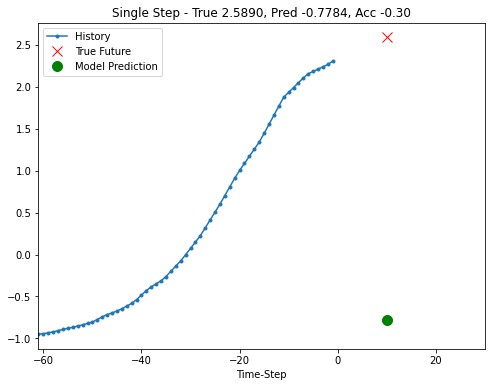

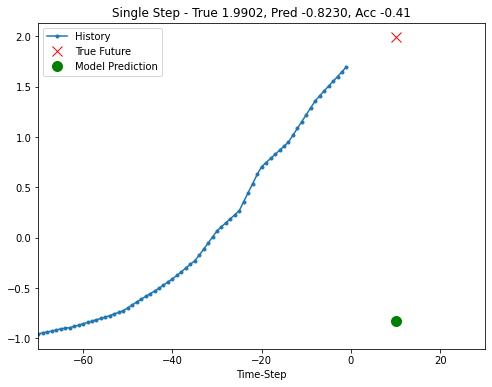

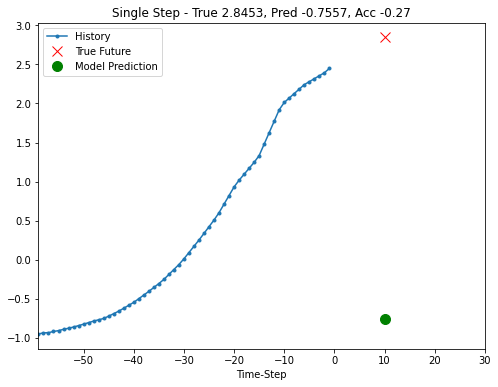

In [ ]:
past_history = 10
future_target = 10
STEP = 2

x_test_single0, y_test_single0 = multivariate_data(dataset, dfInfected_data, series0, series0+1, 
                                               argmax0-past_history, future_target, STEP,
                                               single_step=True)

x_test_single1, y_test_single1 = multivariate_data(dataset, dfInfected_data, series1, series1+1, 
                                               argmax1-past_history, future_target, STEP,
                                               single_step=True)

x_test_single2, y_test_single2 = multivariate_data(dataset, dfInfected_data, series2, series2+1, 
                                               argmax2-past_history, future_target, STEP,
                                               single_step=True)

test_data_single0 = tf.data.Dataset.from_tensor_slices((x_test_single0, y_test_single0))
test_data_single0 = test_data_single0.batch(BATCH_SIZE).repeat()

test_data_single1 = tf.data.Dataset.from_tensor_slices((x_test_single1, y_test_single1))
test_data_single1 = test_data_single1.batch(BATCH_SIZE).repeat()

test_data_single2 = tf.data.Dataset.from_tensor_slices((x_test_single2, y_test_single2))
test_data_single2 = test_data_single2.batch(BATCH_SIZE).repeat()

for x, y in test_data_single0.take(1):
    acc = 1 - (y[0].numpy() - single_step_model_loaded.predict(x)[0][0])/y[0].numpy() 
    plot = show_plot([x[0][:, 0].numpy(), y[0].numpy(),
                    single_step_model_loaded.predict(x)[0]], future_target,
                   f'Single Step - True {y[0].numpy():.4f}, Pred {single_step_model_loaded.predict(x)[0][0]:.4f}, Acc {acc:.2f}')
    plot.show()
    
for x, y in test_data_single1.take(1):
    acc = 1 - (y[0].numpy() - single_step_model_loaded.predict(x)[0][0])/y[0].numpy() 
    plot = show_plot([x[0][:, 0].numpy(), y[0].numpy(),
                    single_step_model_loaded.predict(x)[0]], future_target,
                   f'Single Step - True {y[0].numpy():.4f}, Pred {single_step_model_loaded.predict(x)[0][0]:.4f}, Acc {acc:.2f}')
    plot.show()

for x, y in test_data_single2.take(1):
    acc = 1 - (y[0].numpy() - single_step_model_loaded.predict(x)[0][0])/y[0].numpy() 
    plot = show_plot([x[0][:, 0].numpy(), y[0].numpy(),
                    single_step_model_loaded.predict(x)[0]], future_target,
                   f'Single Step - True {y[0].numpy():.4f}, Pred {single_step_model_loaded.predict(x)[0][0]:.4f}, Acc {acc:.2f}')
    plot.show()

### On Peak, predict 5 days after peak

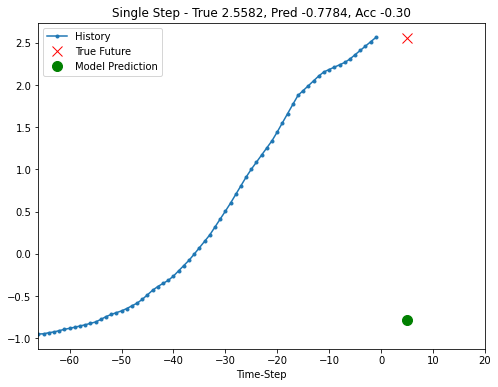

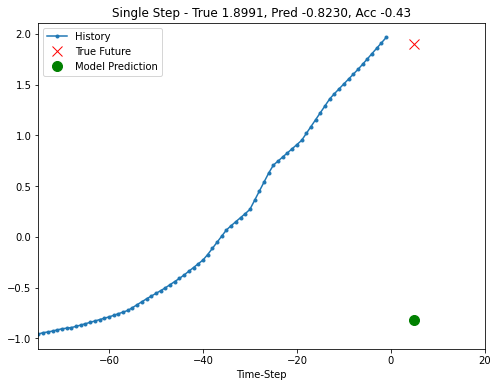

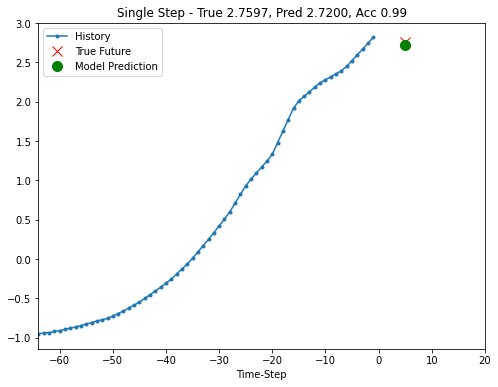

In [ ]:
past_history = 0
future_target = 5
STEP = 2

x_test_single0, y_test_single0 = multivariate_data(dataset, dfInfected_data, series0, series0+1, 
                                               argmax0-past_history, future_target, STEP,
                                               single_step=True)

x_test_single1, y_test_single1 = multivariate_data(dataset, dfInfected_data, series1, series1+1, 
                                               argmax1-past_history, future_target, STEP,
                                               single_step=True)

x_test_single2, y_test_single2 = multivariate_data(dataset, dfInfected_data, series2, series2+1, 
                                               argmax2-past_history, future_target, STEP,
                                               single_step=True)

test_data_single0 = tf.data.Dataset.from_tensor_slices((x_test_single0, y_test_single0))
test_data_single0 = test_data_single0.batch(BATCH_SIZE).repeat()

test_data_single1 = tf.data.Dataset.from_tensor_slices((x_test_single1, y_test_single1))
test_data_single1 = test_data_single1.batch(BATCH_SIZE).repeat()

test_data_single2 = tf.data.Dataset.from_tensor_slices((x_test_single2, y_test_single2))
test_data_single2 = test_data_single2.batch(BATCH_SIZE).repeat()

for x, y in test_data_single0.take(1):
    acc = 1 - (y[0].numpy() - single_step_model_loaded.predict(x)[0][0])/y[0].numpy() 
    plot = show_plot([x[0][:, 0].numpy(), y[0].numpy(),
                    single_step_model_loaded.predict(x)[0]], future_target,
                   f'Single Step - True {y[0].numpy():.4f}, Pred {single_step_model_loaded.predict(x)[0][0]:.4f}, Acc {acc:.2f}')
    plot.show()
    
for x, y in test_data_single1.take(1):
    acc = 1 - (y[0].numpy() - single_step_model_loaded.predict(x)[0][0])/y[0].numpy() 
    plot = show_plot([x[0][:, 0].numpy(), y[0].numpy(),
                    single_step_model_loaded.predict(x)[0]], future_target,
                   f'Single Step - True {y[0].numpy():.4f}, Pred {single_step_model_loaded.predict(x)[0][0]:.4f}, Acc {acc:.2f}')
    plot.show()

for x, y in test_data_single2.take(1):
    acc = 1 - (y[0].numpy() - single_step_model_loaded.predict(x)[0][0])/y[0].numpy() 
    plot = show_plot([x[0][:, 0].numpy(), y[0].numpy(),
                    single_step_model_loaded.predict(x)[0]], future_target,
                   f'Single Step - True {y[0].numpy():.4f}, Pred {single_step_model_loaded.predict(x)[0][0]:.4f}, Acc {acc:.2f}')
    plot.show()

## Multi Step Predictions Around Peak

### Starting on Peak day, Predict 10 days after peak

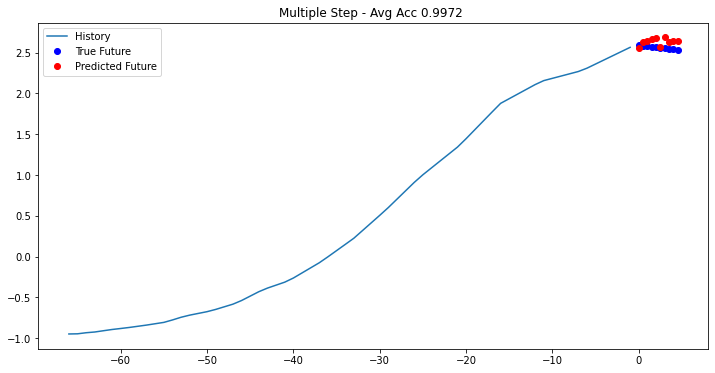

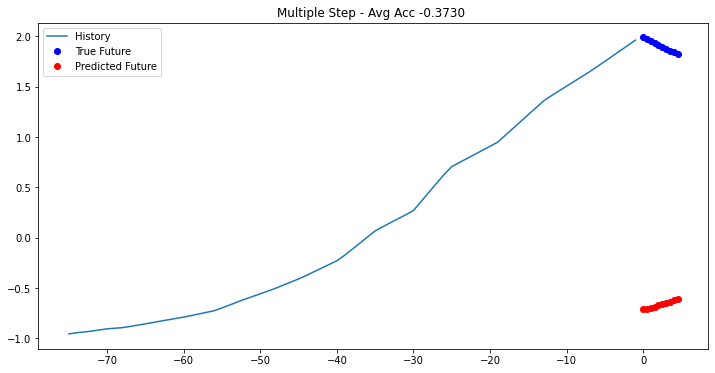

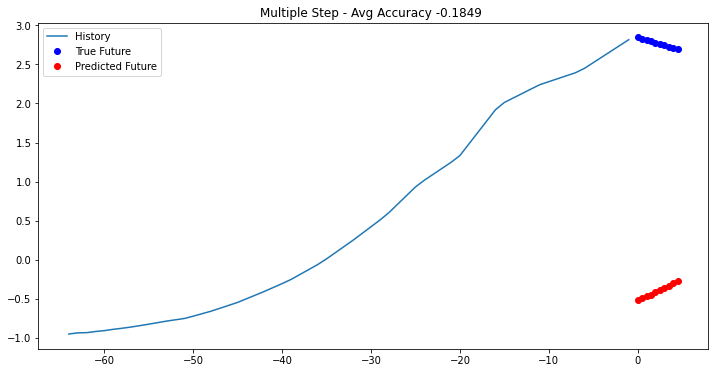

In [ ]:
past_history = 0
future_target = 10
STEP =2

x_test_multi0, y_test_multi0 = multivariate_data(dataset, dfInfected_data, series0, series0+1, 
                                               argmax0-past_history, future_target, STEP)

x_test_multi1, y_test_multi1 = multivariate_data(dataset, dfInfected_data, series1, series1+1, 
                                               argmax1-past_history, future_target, STEP)

x_test_multi2, y_test_multi2 = multivariate_data(dataset, dfInfected_data, series2, series2+1, 
                                               argmax2-past_history, future_target, STEP)
test_data_multi0 = tf.data.Dataset.from_tensor_slices((x_test_multi0, y_test_multi0))
test_data_multi0 = test_data_multi0.batch(BATCH_SIZE).repeat()

test_data_multi1 = tf.data.Dataset.from_tensor_slices((x_test_multi1, y_test_multi1))
test_data_multi1 = test_data_multi1.batch(BATCH_SIZE).repeat()

test_data_multi2 = tf.data.Dataset.from_tensor_slices((x_test_multi2, y_test_multi2))
test_data_multi2 = test_data_multi2.batch(BATCH_SIZE).repeat()

for x, y in test_data_multi0.take(1):
    avg_acc = 1 - np.mean((y[0].numpy() - multi_step_model_loaded.predict(x)[0][0])/y[0].numpy())
    multi_step_plot(x[0], y[0], multi_step_model_loaded.predict(x)[0],
                    f"Multiple Step - Avg Acc {avg_acc:.4f} ")

for x, y in test_data_multi1.take(1):
    avg_acc = 1 - np.mean((y[0].numpy() - multi_step_model_loaded.predict(x)[0][0])/y[0].numpy())
    multi_step_plot(x[0], y[0], multi_step_model_loaded.predict(x)[0],
                    f"Multiple Step - Avg Acc {avg_acc:.4f} ")

for x, y in test_data_multi2.take(1):
    avg_acc = 1 - np.mean((y[0].numpy() - multi_step_model_loaded.predict(x)[0][0])/y[0].numpy())
    multi_step_plot(x[0], y[0], multi_step_model_loaded.predict(x)[0],
                    f"Multiple Step - Avg Accuracy {avg_acc:.4f} ")

### Starting 5 days before peak, Predict the next 10 days

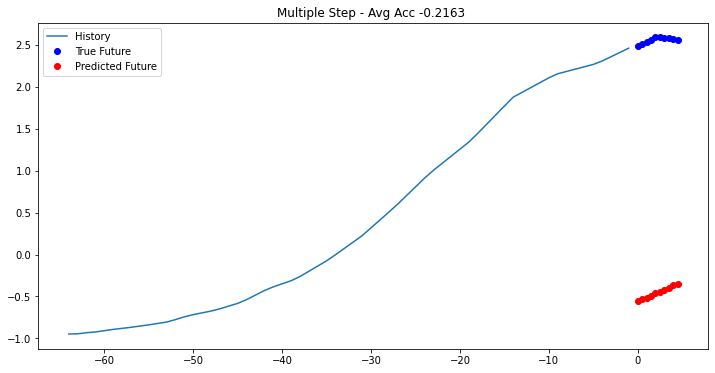

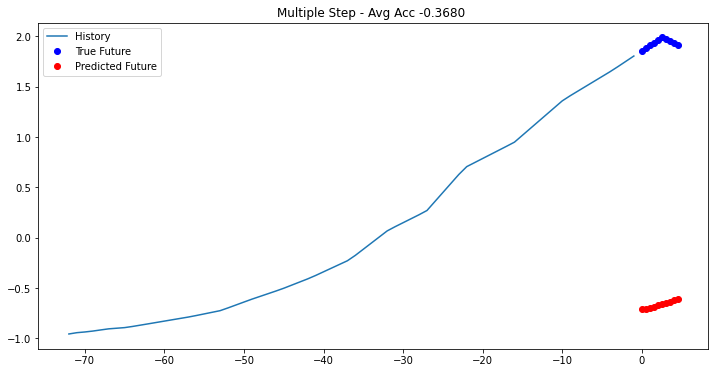

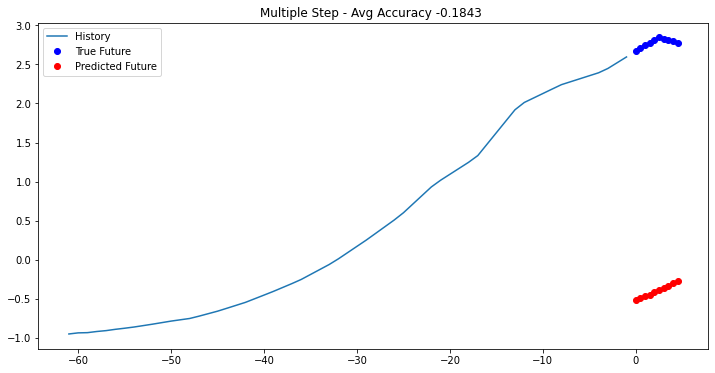

In [ ]:
past_history = 5
future_target = 10
STEP =2

x_test_multi0, y_test_multi0 = multivariate_data(dataset, dfInfected_data, series0, series0+1, 
                                               argmax0-past_history, future_target, STEP)

x_test_multi1, y_test_multi1 = multivariate_data(dataset, dfInfected_data, series1, series1+1, 
                                               argmax1-past_history, future_target, STEP)

x_test_multi2, y_test_multi2 = multivariate_data(dataset, dfInfected_data, series2, series2+1, 
                                               argmax2-past_history, future_target, STEP)
test_data_multi0 = tf.data.Dataset.from_tensor_slices((x_test_multi0, y_test_multi0))
test_data_multi0 = test_data_multi0.batch(BATCH_SIZE).repeat()

test_data_multi1 = tf.data.Dataset.from_tensor_slices((x_test_multi1, y_test_multi1))
test_data_multi1 = test_data_multi1.batch(BATCH_SIZE).repeat()

test_data_multi2 = tf.data.Dataset.from_tensor_slices((x_test_multi2, y_test_multi2))
test_data_multi2 = test_data_multi2.batch(BATCH_SIZE).repeat()

for x, y in test_data_multi0.take(1):
    avg_acc = 1 - np.mean((y[0].numpy() - multi_step_model_loaded.predict(x)[0][0])/y[0].numpy())
    multi_step_plot(x[0], y[0], multi_step_model_loaded.predict(x)[0],
                    f"Multiple Step - Avg Acc {avg_acc:.4f} ")

for x, y in test_data_multi1.take(1):
    avg_acc = 1 - np.mean((y[0].numpy() - multi_step_model_loaded.predict(x)[0][0])/y[0].numpy())
    multi_step_plot(x[0], y[0], multi_step_model_loaded.predict(x)[0],
                    f"Multiple Step - Avg Acc {avg_acc:.4f} ")

for x, y in test_data_multi2.take(1):
    avg_acc = 1 - np.mean((y[0].numpy() - multi_step_model_loaded.predict(x)[0][0])/y[0].numpy())
    multi_step_plot(x[0], y[0], multi_step_model_loaded.predict(x)[0],
                    f"Multiple Step - Avg Accuracy {avg_acc:.4f} ")

### Stargin 5 days after peak, Predict the next 10 days

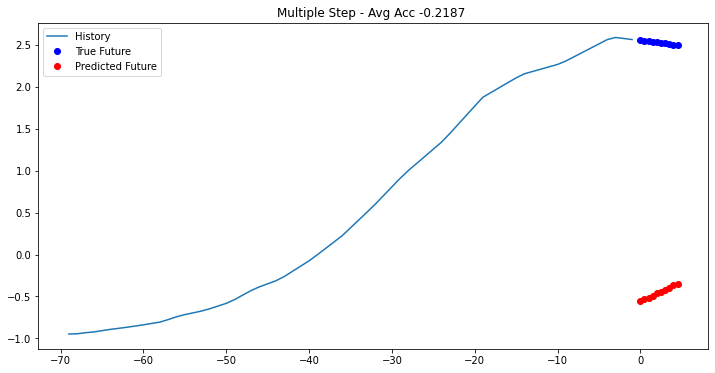

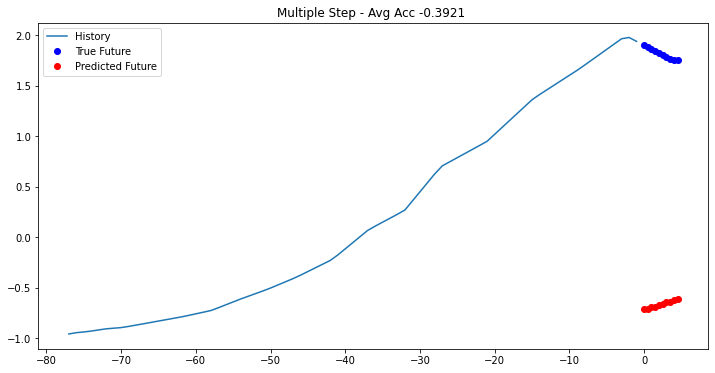

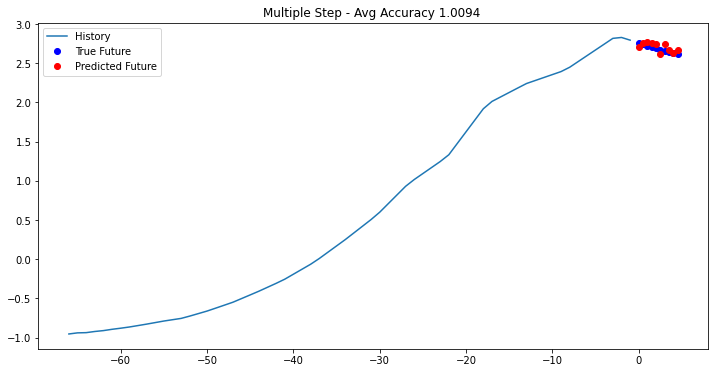

In [ ]:
past_history = -5
future_target = 10
STEP =2

x_test_multi0, y_test_multi0 = multivariate_data(dataset, dfInfected_data, series0, series0+1, 
                                               argmax0-past_history, future_target, STEP)

x_test_multi1, y_test_multi1 = multivariate_data(dataset, dfInfected_data, series1, series1+1, 
                                               argmax1-past_history, future_target, STEP)

x_test_multi2, y_test_multi2 = multivariate_data(dataset, dfInfected_data, series2, series2+1, 
                                               argmax2-past_history, future_target, STEP)
test_data_multi0 = tf.data.Dataset.from_tensor_slices((x_test_multi0, y_test_multi0))
test_data_multi0 = test_data_multi0.batch(BATCH_SIZE).repeat()

test_data_multi1 = tf.data.Dataset.from_tensor_slices((x_test_multi1, y_test_multi1))
test_data_multi1 = test_data_multi1.batch(BATCH_SIZE).repeat()

test_data_multi2 = tf.data.Dataset.from_tensor_slices((x_test_multi2, y_test_multi2))
test_data_multi2 = test_data_multi2.batch(BATCH_SIZE).repeat()

for x, y in test_data_multi0.take(1):
    avg_acc = 1 - np.mean((y[0].numpy() - multi_step_model_loaded.predict(x)[0][0])/y[0].numpy())
    multi_step_plot(x[0], y[0], multi_step_model_loaded.predict(x)[0],
                    f"Multiple Step - Avg Acc {avg_acc:.4f} ")

for x, y in test_data_multi1.take(1):
    avg_acc = 1 - np.mean((y[0].numpy() - multi_step_model_loaded.predict(x)[0][0])/y[0].numpy())
    multi_step_plot(x[0], y[0], multi_step_model_loaded.predict(x)[0],
                    f"Multiple Step - Avg Acc {avg_acc:.4f} ")

for x, y in test_data_multi2.take(1):
    avg_acc = 1 - np.mean((y[0].numpy() - multi_step_model_loaded.predict(x)[0][0])/y[0].numpy())
    multi_step_plot(x[0], y[0], multi_step_model_loaded.predict(x)[0],
                    f"Multiple Step - Avg Accuracy {avg_acc:.4f} ")